In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
import src.Modules.Loaders.DataFormatter as DF
from src.DE_simulation import fickian_diffusion, Diffusion_eqn, simple_pulling_diffusion, simple_adhesion_diffusion
from scipy.integrate import odeint
from get_params import get_pulling_params, get_adhesion_params, get_heterog_params

def unique_inputs(inputs):
    x = np.unique(inputs[:,0])
    t = np.unique(inputs[:,1])
    return x,t

def DE_sim(x, t, q, IC, Diffusion_function):
    
    sol = odeint(Diffusion_eqn, IC, t, args=(x, q, Diffusion_function))
    sol = sol.T
    return sol

def MSE(a,b):
    assert a.shape == b.shape
    return ((a - b)**2).mean()


In [8]:
scenario = "pulling"

BINNTimes = []
BINNPDETimes = []
ABMTimes = []
MFTimes = []
InterpPDETimes = []

data_path = "../../data/"

if scenario == "pulling":
    file_name_header = "simple_pulling_mean_25"
    param_combos = get_pulling_params()
    int_str = "Ppull"
elif scenario == "adhesion":
    file_name_header = "simple_adhesion_mean_25"
    param_combos = get_adhesion_params()
    int_str = "Padh"
elif scenario == "adhesion_pulling":
    file_name_header = "adhesion_pulling_mean_25"
    param_combos = get_heterog_params()
    
    
for params in param_combos:
    
    if scenario == "adhesion_pulling":
        PmH, PmP, Pp, Padh, Ppull, alpha = params
        file_name_tail = f'_PmH_{PmH}_PmP_{PmP}_Pp_{Pp}_Padh_{Padh}_Ppull_{Ppull}_alpha_{alpha}'
    else:
        Pm, Pp, Pint = params
        file_name_tail = f'_Pm_{Pm}_Pp_0.0_{int_str}_{Pint}'

    file_name = f'{file_name_header}{file_name_tail}'
    mat = np.load(data_path+file_name+".npy",allow_pickle=True).item()
    ABMTimes.append(mat['time_all'])
    
    
    ### Collect MF PDE Times
    if scenario == "adhesion" and Pint > 0.75:
        pass
    else:
        MF_file_name = f"../../results/timing/MF_PDE_sim_{file_name}.npy"
        mat = np.load(MF_file_name,allow_pickle=True).item()
        MFTimes.append(mat['time'])
    
    ### Collect Interpolated PDE Times
    #interp_file_name = f"../../results/timing/Interpolated_PDE_sim_{file_name}.npy"
    #mat = np.load(interp_file_name,allow_pickle=True).item()
    #InterpPDETimes.append(mat['time'])
        
    for i in np.arange(5):

        if scenario == "adhesion_pulling":
            binn_file_name = f"../../results/timing/ DMLP_training_replicate_{i}_{file_name}_pde_weight_10000.0.npy"
        else: 
            binn_file_name = f"../../results/timing/DMLP_training_replicate_{i}_{file_name}_pde_weight_10000.0.npy"
        mat = np.load(binn_file_name,allow_pickle=True).item()
        BINNTimes.append(mat['time'])
        
        binn_PDE_filename = f"../../results/PDE_sims/PDE_sim_DMLP_{file_name}_pde_weight_10000.0.npy"
        mat = np.load(binn_PDE_filename,allow_pickle=True).item()
        BINNPDETimes.append(mat['time'])
        
BINNTimes = np.array(BINNTimes)
BINNPDETimes = np.array(BINNPDETimes)
ABMTimes = np.array(ABMTimes)
MFTimes = np.array(MFTimes)
InterpPDETimes = np.array(InterpPDETimes)

print(np.mean(np.log10(ABMTimes)),
      np.mean(np.log10(BINNTimes)),
      np.mean(np.log10(MFTimes)),
      np.mean(np.log10(BINNPDETimes)),
      np.mean(np.log10(InterpPDETimes)))
        

3.3291440909377847 4.520537038660515 -0.34929316553809625 1.9314771536382702 nan


/opt/tcnjhpc/Python-3.9.12/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/tcnjhpc/Python-3.9.12/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [9]:
ABMmean = np.round(np.mean(ABMTimes)/60,1)
ABMstd = np.round(np.std(ABMTimes)/60,2)
BINNmean = np.round(np.mean(BINNTimes)/3600,1)
BINNstd = np.round(np.std(BINNTimes)/3600,2)
BINNPDEmean = np.round(np.mean(BINNPDETimes),1)
BINNPDEstd = np.round(np.std(BINNPDETimes),2)
MFmean = np.round(np.mean(MFTimes),1)
MFstd = np.round(np.std(MFTimes),2)

print(f" {scenario} & {ABMmean} ({ABMstd}) minutes & {BINNmean} ({BINNstd}) hours & {MFmean} ({MFstd}) seconds & {BINNPDEmean} ({BINNPDEstd}) seconds \\\\ \\hline ")

 pulling & 39.9 (15.8) minutes & 10.0 (3.99) hours & 0.5 (0.16) seconds & 164.8 (156.9) seconds \\ \hline 


/tmp/ipykernel_189345/1119338085.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels,fontsize=20)


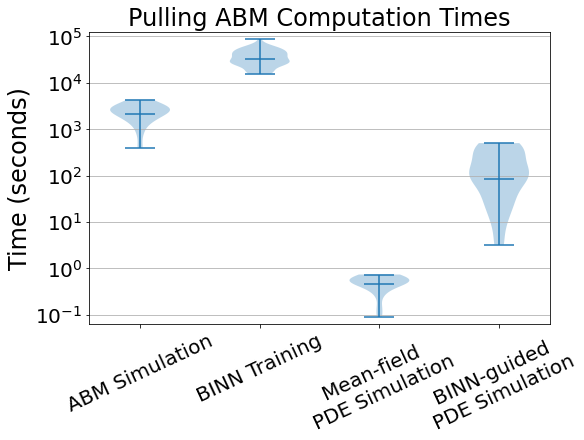

In [10]:
# Create a figure instance
fig = plt.figure(figsize=(8,6), layout="constrained")
fontsize = 24

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
bp = ax.violinplot([np.log10(ABMTimes), 
                    np.log10(BINNTimes), 
                    np.log10(MFTimes),
                    np.log10(BINNPDETimes)],#,
                    #np.log10(InterpPDETimes)],
                  showmeans=True,
                  showextrema=True)

if scenario == "pulling":
    title = "Pulling ABM Computation Times"
elif scenario == "adhesion":
    title = "Adhesion ABM Computation Times"
elif scenario == "adhesion_pulling":
    title = "Pulling & Adhesion ABM Computation Times"

ax.set_title(title,fontsize=fontsize)
ax.set_ylabel("Time (seconds)",fontsize=fontsize)
ax.set_xticks([1.0, 2.0, 3.0, 4.0])#, 5.0])
ax.set_xticklabels(["ABM Simulation",
                    "BINN Training",
                    "Mean-field \nPDE Simulation",
                    "BINN-guided \nPDE Simulation"],#,#"Interpolated BINN \nPDE Simulation"],
                   fontsize=20,
                   rotation=25)
ax.set_ylim([-1.2,5.1])
yticks = ax.get_yticks()
yticklabels = ["$10^{"+str(int(y))+"}$" for y in yticks]
ax.set_yticklabels(yticklabels,fontsize=20)
plt.grid(axis="y")
#plt.subplots_adjust(top=0.95, bottom = .21, right = .99)
plt.savefig(f"../../results/figures/{scenario}_walltime.pdf",format="pdf")